In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
modelstr = "plip" # "tile2vec", "vit_iid","clip","plip"

In [3]:
if modelstr == "tile2vec":
    embed_dict_path = "/home/lofi/lofi/src/outputs_tile2vec/train_sampled_inference_z_embeds.obj"
elif modelstr == "vit_iid":
    embed_dict_path = "/home/lofi/lofi/src/outputs_vit/train_vit_iid_sampled_inference_z_embeds.obj"
elif modelstr == "clip": 
    embed_dict_path = "/home/lofi/lofi/src/outputs_clip/train_clip_sampled_inference_z_embeds.obj"
elif modelstr == "plip":
    embed_dict_path = "/home/lofi/lofi/src/outputs_plip/train_plip_sampled_inference_z_embeds.obj"

In [4]:
from k2 import K2Processor

In [5]:
args = {"datatype":"histo",
        "k":15,
        "quantizer_type":"kmeans",
        "embeddings_path":embed_dict_path,
        "embeddings_type":"dict",
        "mapping_path": None,
        "sample_size":4440,
        "sample_scheme":"random",
        "dataset_path":"/home/data/tinycam/train/train.hdf5",
        "verbosity": "full",
        "so_dict_path": "/home/lofi/lofi/src/outputs/train_so_dict.obj"}
# ViT: "/home/k2/K2/src/outputs_vit/train_vit_iid_chunkid_position.obj"
proc = K2Processor(args)

Embeddings path provided, loading embeddings...


In [6]:
proc.fit_quantizer()

Chosen KMeans model for quantization...
sampled 12 known salient objects!
total embeds: 4440
collapsing from dim 512 --> 2


/home/envs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


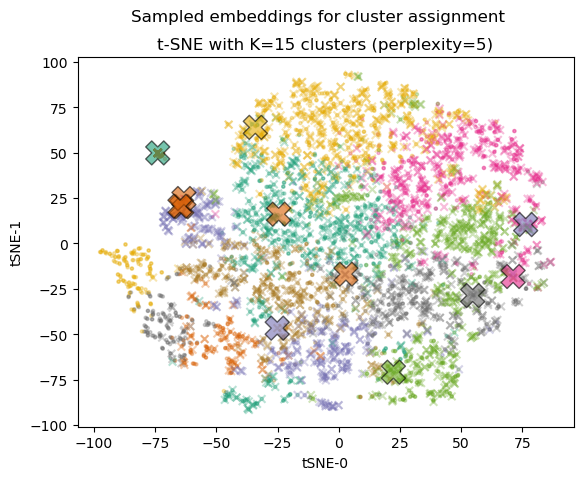

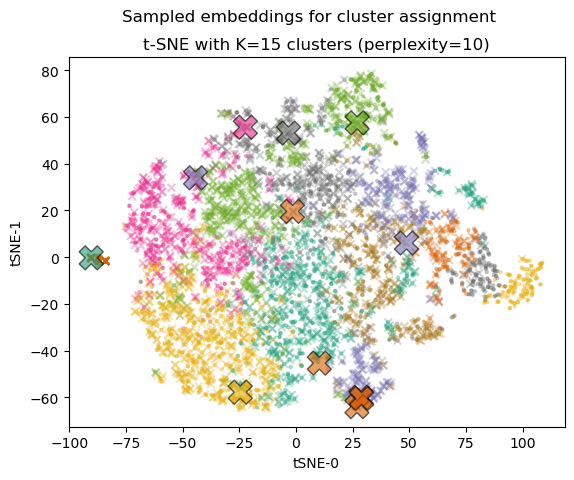

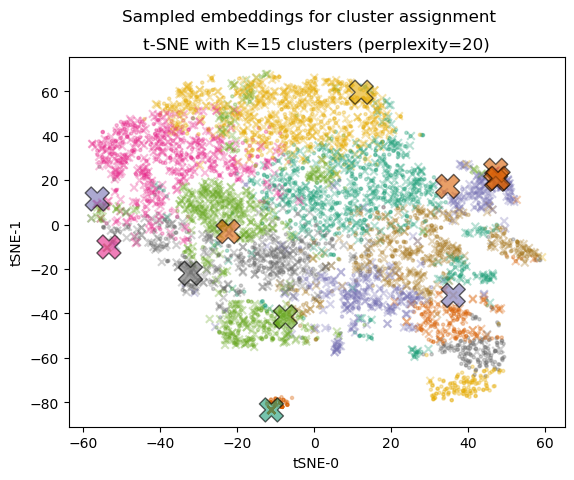

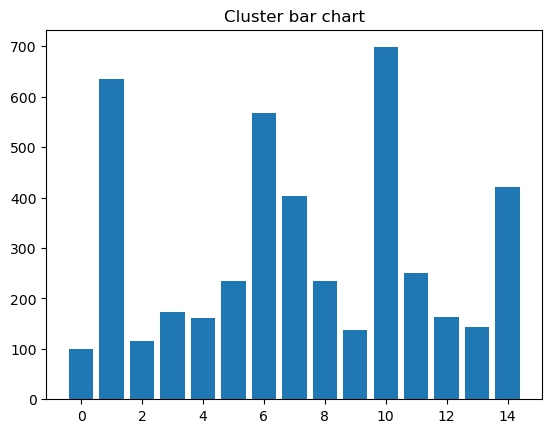

In [7]:
proc.visualize_quantizer()

# Sprite construction

In [8]:
if modelstr == "tile2vec":
    G_dir = "/home/data/tinycam/train/Gs_tile2vec"
elif modelstr == "vit_iid":
    G_dir = "/home/data/tinycam/train/Gs_vit_iid"
elif modelstr == "clip":
    G_dir = "/home/data/tinycam/train/Gs_clip"
elif modelstr == "plip":
    G_dir = "/home/data/tinycam/train/Gs_plip"

In [9]:
import utils
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from utils import visualize_quantizedZ, visualize_Z

/home/data/tinycam/train/Zs_plip/Z-tumor_045.npy


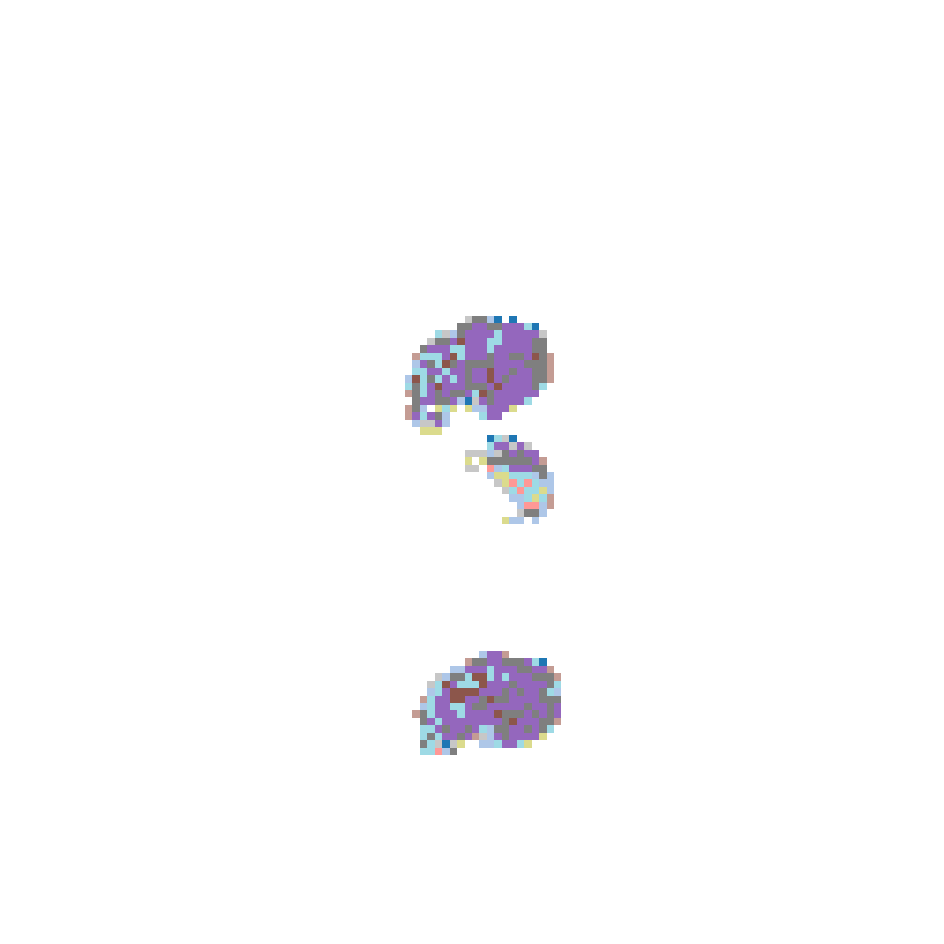

In [11]:
Z_id = "Z-tumor_045.npy"
Z_pathdir = "/home/data/tinycam/train/Zs_" + modelstr

Z_path = Z_pathdir + "/" + Z_id
if modelstr == "vit_iid":
    visualize_Z(Z_path, proc.quantizer, mode="memmap")
else:
    print(Z_path)
    visualize_Z(Z_path, proc.quantizer)

In [12]:
Z = np.load(Z_path)
np.sum(np.sum(Z, axis=(2)) != 0)

520

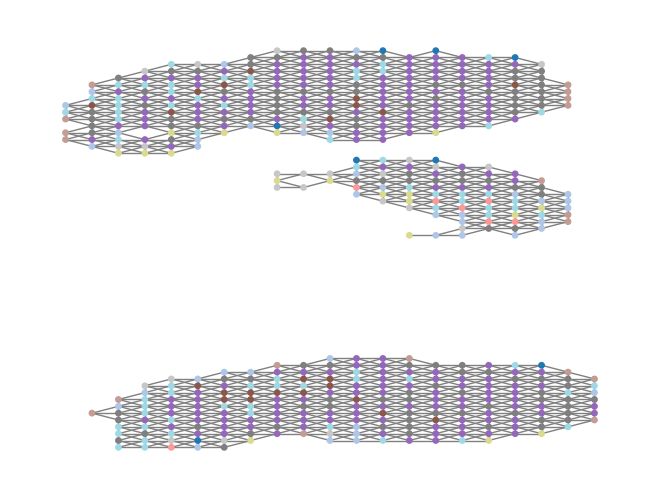

In [13]:
G_id = "G-tumor_045"
G_path = G_dir + "/" + G_id
G = utils.deserialize(G_path)

sprite = utils.construct_sprite(G, proc)
utils.visualize_sprite(sprite, modality="image")

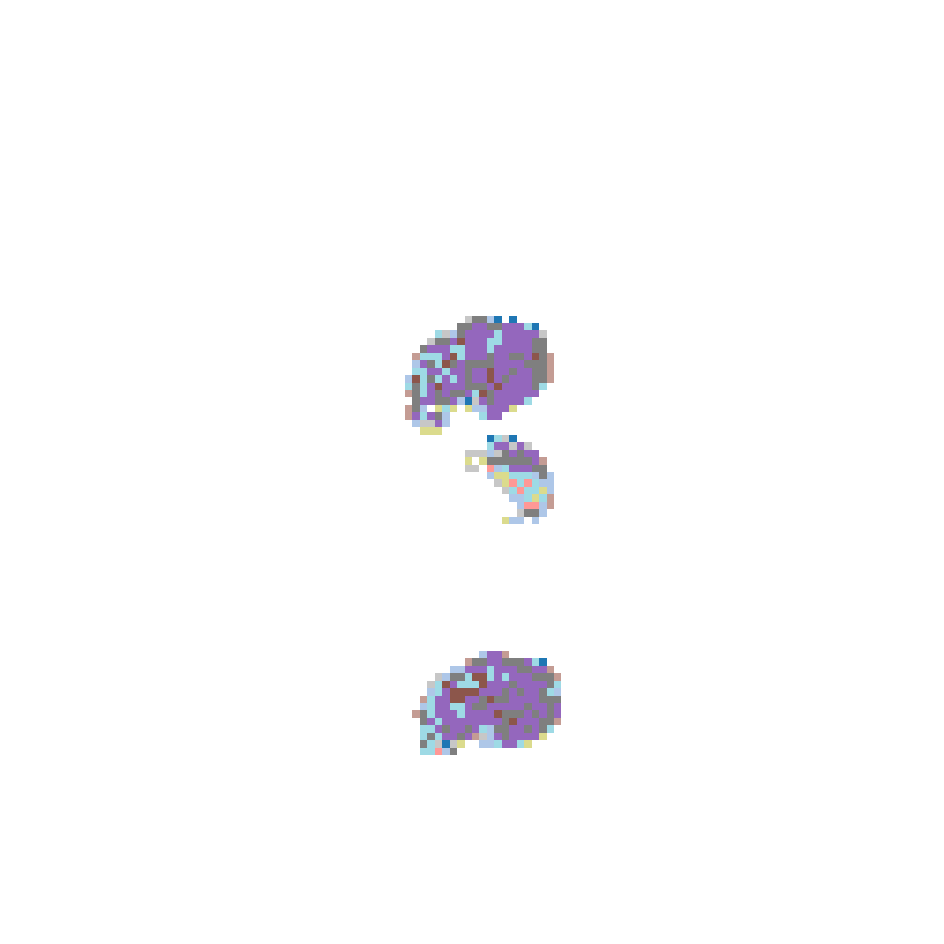

In [14]:
sprite_map = utils.convert_graph2arr(sprite)
visualize_quantizedZ(sprite_map)

In [15]:
from k2 import K2Model

In [16]:
# # hyperparameter sweep
# Ks = [10,15,20,25,30]
# rs = [0,1,2,4,8]
# alphas = [0.01, 0.025, 0.05, 1e10]
# taus = [0,1,2]

In [17]:
label_dict = utils.deserialize("/home/data/tinycam/train/" + modelstr + "-label_dict.pkl")
hparams = {"alpha": 0.01, "tau": 1, "lambda": 0.5}
args = {"modality":"image",
        "processor":proc,
        "r":2,
        "variant": "inferential",
        "hparams": hparams,
        "train_graph_path": G_dir,
        "train_label_dict": label_dict}

In [18]:
k2m = K2Model(args)

In [19]:
k2m.create_train_array()

Creating K2 training array...:   0%|          | 0/222 [00:00<?, ?it/s]

Complete! Created a training array for few-shot classification...
Number of training examples: 222
Number of Kk features: 135


In [20]:
k2m.fit_kernel()

Normalizing training data with TF-IDF...
Differential Expression with alpha,tau: 0.01,1


<BarContainer object of 135 artists>

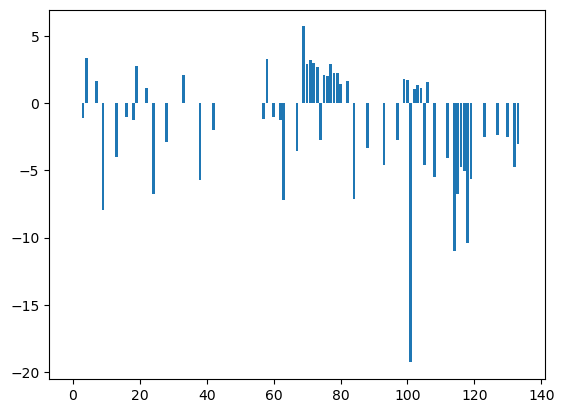

In [21]:
plt.bar(x=range(len(k2m.B)), height=list(k2m.B))

In [22]:
G_file = "/home/data/tinycam/test/Gs_" + modelstr + "/G-test_001"
G = utils.deserialize(G_file)
P = k2m.prospect(G)
print(P)

Graph with 1380 nodes and 5134 edges


Displaying motif graph with log10 scaling


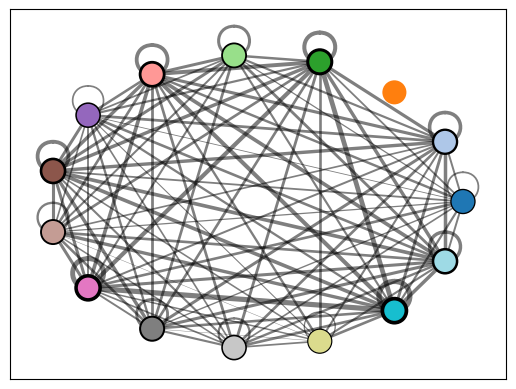

In [23]:
k2m.visualize_motif_graph(G)

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


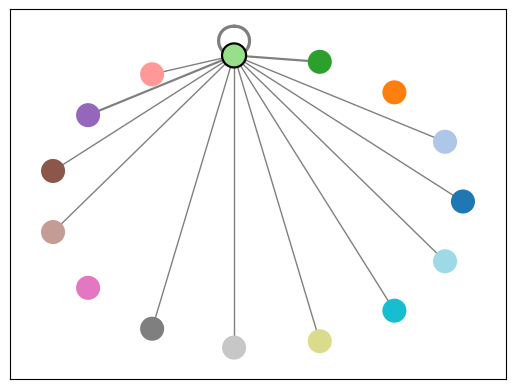

In [24]:
k2m.visualize_motif_graph()

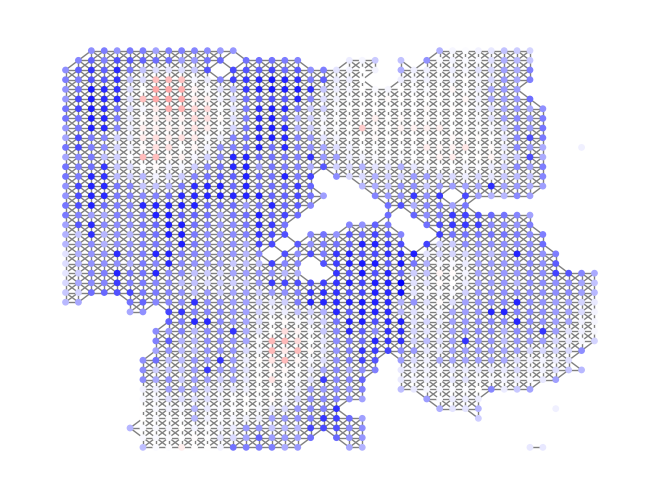

In [25]:
k2m.visualize_prospect_graph(P)

311.44445224969337


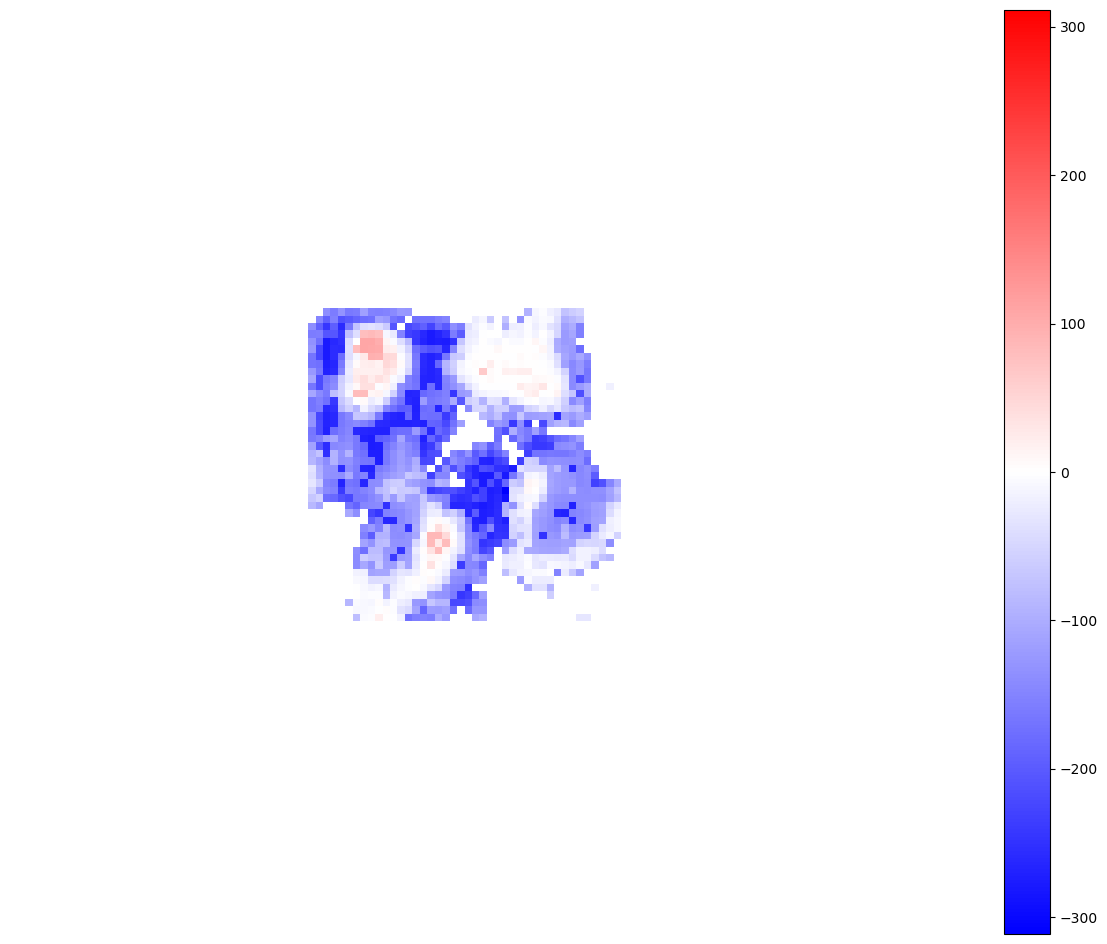

In [26]:
k2m.visualize_prospect_map(P)